# Cross‑sectional long‑only momentum с таргетированием волатильности

_Оценивается EWM‑сглаживанием дневной доходности, а веса подбираются оптимизатором так, чтобы максимизировать коэфициент Шарпа при ограничениях (min_weights=0, cap на актив, бюджет до 2×), после чего портфель (при желании) масштабируется под целевую волатильность_

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
#%matplotlib inline
import yfinance as yf
from tqdm.notebook import tqdm

In [2]:
import datetime as dt
import os, re
import warnings
warnings.filterwarnings('ignore')

In [3]:
plt.rcParams['font.family'] = 'Times New Roman'

In [4]:
# US business month start dates + US Federal Holidays
# Creates a CustomBusinessMonthBegin offset that accounts for the first business day of the month and skips US federal holidays.
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessMonthBegin

us_bms = CustomBusinessMonthBegin(calendar=USFederalHolidayCalendar())

pd.date_range("2024-01-01", "2024-12-31", freq=us_bms)

DatetimeIndex(['2024-01-02', '2024-02-01', '2024-03-01', '2024-04-01',
               '2024-05-01', '2024-06-03', '2024-07-01', '2024-08-01',
               '2024-09-03', '2024-10-01', '2024-11-01', '2024-12-02'],
              dtype='datetime64[ns]', freq='CBMS')

In [5]:
from cvxpy import installed_solvers
print(installed_solvers())      # will show what cvxpy sees

['CLARABEL', 'ECOS', 'ECOS_BB', 'OSQP', 'SCIP', 'SCIPY', 'SCS']


In [6]:
# Data loader
def load_yf(tickers, start, end):
    """
    Download daily adjusted close prices via yfinance and compute log returns.

    :tickers: list of tickers to download
    :start:   start date (YYYY-MM-DD)
    :end:     end date (YYYY-MM-DD)

    :return: price (daily adjusted close prices), ret (daily log returns, NaN-rows removed).
    """
    price  = yf.download(tickers, start=start, end=end, progress=False,auto_adjust=True,group_by="column")["Close"] # it is adj close
    price = price.dropna(how="all")
    ret   = np.log(price/price.shift())
    return price, ret.dropna(how="all")

In [7]:
# Strategy parameters
etfs          = ["SPY", "QQQ", "IWF", "IWD", "TLT", "BIL", "LQD", "GLD", "XLV", "XLI", "XLF", "XLK"]           # asset example
start_date    = "2010-01-01"
end_date      = "2025-08-05"

# Load price & returns data
df_prices, df_returns = load_yf(etfs, start_date, end_date)

# Add constant 'cash' asset: price = 1.0 $, return = 0.0
df_prices['CASH']  = 1.0
df_returns['CASH'] = 0.0

#df_returns = df_returns.fillna(0)

In [8]:
risk_cols = df_returns.columns.difference(['CASH'])
risk_cols

Index(['BIL', 'GLD', 'IWD', 'IWF', 'LQD', 'QQQ', 'SPY', 'TLT', 'XLF', 'XLI',
       'XLK', 'XLV'],
      dtype='object', name='Ticker')

In [9]:
# Keep only dates with prices for all risky assets
mask = df_returns[risk_cols].notna().all(axis=1)
df_returns = df_returns.loc[mask].copy()
df_prices  = df_prices.loc[df_returns.index].copy()

In [10]:
# Trading & optimization settings
cost_rate     = 0.0005                    # transaction cost rate (5 bps per trade)
train_month    = 10                       # In-Sample period (months)
test_month     = 1                        # Out-Of-Sample period length in months
#risk_aversion = 1.0                       # MV-utility lambda
mom_lookback  = 60                        # momentum lookback L_b, subject to optimization
skip_days     = 0                         # lookback skip (L_s from TSMOM)
target_vol    = 0.2                      # e.g., 0.15 to enable volatility targeting
days_in_year  = 252

# Cистема лотов
initial_capital = 1_000_000               # portfolio nominal value (USD)
round_to_share  = True                    # whether to trade whole shares (True/False)

In [11]:
# Additional functions
def Return(rets):     return np.mean(rets) * days_in_year                                       # annualized return estimate

def Volatility(rets): return np.std(rets)  * np.sqrt(days_in_year)                              # annualized volatility estimate
 
def SharpeRatio(rets): vol = Volatility(rets);  return Return(rets) / vol if vol else np.nan    # annualized sharpe ratio

def OverfitScore(sh_tr, sh_va):
    """
    Overfitting score: |log(|sh_tr|/sh_va)| — avoids NaN when sh_tr is negative
    
    :return: absolute log-ratio of IS/OOS Sharpe, large values - stronger overfit
    """
    if not (np.isfinite(sh_tr) and np.isfinite(sh_va) and sh_va > 0):
        return 1e6
    ratio = (abs(sh_tr) + 1e-12) / max(sh_va, 1e-12)
    return abs(np.log(ratio))

def StatisticsCalc(rets, bh, name="_"):
    """
    Compute performance metrics for the strategy (`rets`) and, if provided, for the benchmark (`bh`).

    rets : strategy log returns (index-aligned).
    bh : benchmark log returns (index-aligned). If None, only strategy stats are returned.
    name : row label for the strategy.

    :return: columns: ["Sharpe", "Ann ret", "Vol"], rows: [name] and, if `bh` is provided, ["BH"].
    """
    rows, idx = [], []
    s = SharpeRatio(rets);  r = Return(rets);  v = Volatility(rets)
    rows.append([s, r, v]); idx.append(name)

    if bh is not None:
        s_b = SharpeRatio(bh);  r_b = Return(bh);  v_b = Volatility(bh)
        rows.append([s_b, r_b, v_b]); idx.append("BH")

    return pd.DataFrame(rows, columns=["Sharpe", "Ann ret", "Vol"], index=idx)

**`allocate_by_capital(...)`**: распределяет капитал по активам согласно целевым весам с учётом потолка на одну позицию и, при необходимости, округления до целых лотов. Поддерживает как фракционные доли, так и «целые акции». Умеет работать с плечом, если сумма риск-весов > 1 (тогда 'CASH' может стать отрицательным).

Используется в портфельной логике для превращения целевых весов в реализованные веса под ограничениями лотов/капов.

Что делает пошагово:

1. Формирует множество риск-активов: `risk = weights.index.difference(['CASH'])`.
2. Вычисляет желаемый «левередж»: `leverage = sum(weights[risk])`. `levered = (leverage > 1 + 1e-12)`. Если да — разрешено заимствование и бюджет покупок увеличивается до `purchase_budget = capital * leverage`. Если нет — покупаем на equity: `purchase_budget = capital`.
3. Задаёт долларовые цели и потолок на актив:

Режимы: `int_shares=False` (фракционные доли) и `int_shares=True` (целые лоты)

In [12]:
def allocate_by_capital(weights, price_row, capital, int_shares=True, w_lim=0.8):
    """
    Allocate `capital` across risky assets (and 'CASH') according to target `weights` subject to a per-asset cap and optional integer-share rounding.

    :weights:    target weights indexed by tickers plus 'CASH'. Risky weights may sum to >1.0 to request leverage.
    :price_row:  latest prices for risky tickers (no 'CASH' entry).
    :capital:    equity capital used as the denominator for portfolio weights.
    :int_shares: True = buy integer numbers of shares via a greedy top-up loop, False = allow fractional allocations.
    :w_lim:      per-asset weight cap relative to equity in non-levered mode and relative to equity*leverage in levered mode.

    :return:     realized portfolio weights over equity for each risky asset and 'CASH'. 
                 Weights sum to 1.0. 
                 'CASH' may be negative only when leverage is requested (sum of risky weights > 1).
    """
    # Risky universe (exclude 'CASH')
    risk = weights.index.difference(['CASH'])

    # Infer leverage from target risky-weight sum
    eps = 1e-12                                   # only for numerical stability when compared with 1
    leverage = float(weights[risk].sum())         # sum of risky weights (= desired gross exposure / equity)
    levered  = leverage > 1.0 + eps               # borrowing allowed only budget > 1
    purchase_budget = capital * (leverage if levered else 1.0)

    # Target $ per asset with a per-asset cap
    dollars_risk = weights[risk] * capital
    dollars_cap  = np.minimum(dollars_risk, w_lim * (purchase_budget if levered else capital))   # recalculation of dollar limits based on leverage

    if not int_shares:
        # Fractional route: realized weights = capped dollars / equity
        w_frac = (dollars_cap / capital).fillna(0)
         # Residual cash: allow negative cash only when leverage is requested
        cash_w = (1.0 - w_frac.sum()) if levered else max(0.0, 1.0 - w_frac.sum())
        return pd.concat([w_frac, pd.Series({'CASH': cash_w})])

    price_r = price_row[risk]         # prices for risky tickers only
    
    # Initial integer lots from capped dollar targets
    shares = (dollars_cap / price_r).fillna(0).astype(int)
    spend  = (shares * price_r).sum()
    cash   = (purchase_budget if levered else capital) - spend       # cash left after initial purchase

    # Underfunding vs per-asset *cap* targets (not original weights)
    diff = dollars_cap - shares * price_r
    min_price = price_r.replace([np.inf, -np.inf], np.nan).dropna().min()

    # Greedy top-up: buy +1 share of the most under-funded asset while cash and cap allow
    while (cash >= min_price) and (diff.max() > 0):
        idx = diff.idxmax()          # asset with the largest remaining gap to its cap
        p   = price_r[idx]

        # Respect per-asset cap and available cash: (shares+1)*p <= dollars_cap[idx]
        if (p <= cash) and ((shares[idx] + 1) * p <= dollars_cap[idx] + 1e-12):
            shares[idx] += 1
            cash        -= p
            diff[idx]    = dollars_cap[idx] - shares[idx] * p
        else:
            # This ticker cannot be increased further => remove from competition
            diff[idx] = -np.inf

    # Final weights: realized $ exposure / equity; cash = residual
    spend   = (shares * price_r).sum()
    w_risk  = (shares * price_r) / capital
    cash_w  = (1.0 - w_risk.sum()) if levered else max(0.0, 1.0 - w_risk.sum())
    weights_all = pd.concat([w_risk, pd.Series({'CASH': cash_w})])

    # No further normalization/clipping needed — the sum is guaranteed to be 1
    # assert np.isclose(weights_all.sum(), 1.0, atol=1e-10)

    # Sanity checks (dev only)
    # Per-asset cap in weight-space: w_lim × (1 or leverage)
    per_asset_cap = w_lim * (leverage if levered else 1.0)
    assert (weights_all.drop('CASH') <= per_asset_cap + 1e-12).all(), \
        f"Нарушен лимит позиции: cap={per_asset_cap:.4f}, max={weights_all.drop('CASH').max():.4f}"
    assert np.isfinite(weights_all).all(), "NaN/Inf в weights_all"
    assert abs(weights_all.sum() - 1.0) < 1e-10, f"Сумма весов != 1 (sum={weights_all.sum():.12f})"
    assert (weights_all.drop('CASH') >= -1e-12).all(), "Отрицательные веса (long-only)"

    return weights_all

**Основные функции:**

**`tune_hyperparams_optuna(...)`**: оптимизирует гиперпараметры через Optuna на хронологическом train/valid-сплите `ret_is`.
Что делает внутри:
1. семплирует `mom_lb`,`l1_coef`, `l2_coef`, `max_weights` и (опционально) `target_vol`;
2. строит EWM-моментум-прогноз `mu_vec` по `risk_cols` со сдвигом `skip_days`;
3. клонирует и настраивает estimator (`EmpiricalPrior` + `EWCovariance`), обучает на `train`;
4. при заданном `target_vol` масштабирует веса, соблюдая `max_weights` и `budget`;
5. считает Sharpe на train/valid и минимизирует цель: `score = -Sharpe_valid + overfit_penalty + vol_penalty`;
6. возвращает лучшие: `mom_lookback`, `target_vol` (если тюнился) и прочими params.

**`backtest_walk_forward(...)`**: делает walk-forward бэктест с тюнингом на каждом IS-окне и (опционально) внутритестовой ребалансировкой.
Что делает внутри:
1. инициализирует `capital = initial_capital`, логи pnl/весов/mom_lb;
2. для каждого фолда `cv`: тюнит параметры через `tune_hyperparams_optuna`, обучает `estimator`, получает базовые веса;
3. строит календарь ребалансов `rebal_dates` (или без него — одна ребалансировка на границах OOS);
4. на каждом ребалансе пересчитывает моментум по `rolling_train`, переобучает модель, при необходимости масштабирует к `target_vol_fold` с учётом `max_weights` и `budget`;
5. конвертирует целевые веса в реализованные через `allocate_by_capital`;
6. считает издержки `cost_rate` на границе субпериода, PnL `sub_ret.dot(w)`, обновляет `capital` и ведет логи;
7. по завершении склеивает PnL и возвращает: `pnl_out`, `wts` (лог весов), `mom_lb` (лог подбраных Lb).

В `backtest_walk_forward(...)` были добавлены обработки исключений, так как солвер с `MAXIMUM_RATIO` падал на 58 шаге. Добавлены: 1) отбор полноценных колонок по окну, 2) согласование `mu_vec`, 3) проверка `M_eff*max_weights >= budget`, (iv) `try/except` с фолбэком на `SCS`, (v) нулевые веса (кэш) при неудаче.

In [13]:
import optuna    # Optuna‑bayesian optimization
import logging

optuna.logging.set_verbosity(optuna.logging.WARNING)

In [27]:
# Hyperparameter tuning function
def tune_hyperparams_optuna(ret_is,skip_days,estimator,valid_ratio = 0.2, n_trials=80, seed=666, n_jobs=1,
                            tune_target_vol=False, fixed_target_vol=None):
    """
    Tune momentum lookback and regularization for the estimator with an OOS-oriented objective using Optuna. 
    Objective function = overfitting coefficient + penalty for weak Sharpe on validation.

    ret_is :           IS returns used for train/validation split
    skip_days :        signal delay (number of days to shift returns before computing momentum)
    estimator :        base estimator to be configured and fitted inside the objective
    valid_ratio :      fraction of `ret_is` reserved for validation (chronological split)
    n_trials :         number of Optuna trials
    seed :             random seed for the TPE sampler
    n_jobs :           parallel jobs for Optuna
    tune_target_vol :  True = include `target_vol` in the search, otherwise use `fixed_target_vol`.
    fixed_target_vol : target annualized volatility to scale weights to, when `tune_target_vol` is False (default None)

    :return: mom_lookback (mom_lb), l1_coef, l2_coef, max_weights, 
             target_vol (optional, if tune_target_vol=True), other sampled params (if enabled)
    """
    split = int(len(ret_is) * (1 - valid_ratio))
    ret_tr, ret_va = ret_is.iloc[:split], ret_is.iloc[split:]

    def objective(trial):
        # Hyperparameter sampling
        lb   = trial.suggest_int("mom_lb",                 60, 180, step=1)                   # momentum mom_lookback (Lb), in trading days
        #l1   = trial.suggest_float("l1_coef",             1e-5, 0.01, log=True)
        #l2   = trial.suggest_float("l2_coef",             1e-5, 0.02, log=True)
        #th_l = trial.suggest_float("threshold_long",      0.0,  0.05)

        #l1   = trial.suggest_categorical("l1_coef",        [0.001, 0.005, 0.01, 0.015, 0.02])         # l1_coef regularization
        #l2   = trial.suggest_categorical("l2_coef",        [0.001, 0.005, 0.01, 0.015, 0.02])         # l2_coef regularization
        l1   = trial.suggest_float("l1_coef",        0.0, 0.025,   step=0.001)         # l1_coef regularization
        l2   = trial.suggest_float("l2_coef",        0.0, 0.025,   step=0.001)         # l2_coef regularization
        #th_l = trial.suggest_categorical("threshold_long", [0.0, 0.0001, 0.0002, 0.0005])    # daily threshold_long for long entries
        
        mw   = trial.suggest_float("max_weights",          0.4, 1,   step=0.01)             # per-asset cap in weight space, max_weights

        cov_kind = trial.suggest_categorical("cov_kind", ["ewma", "ledoitwolf", "oas", "shrunk"])
        if cov_kind == "shrunk": shrink = trial.suggest_float("shrinkage", 0.0, 0.5, step=0.01)          # доля усадки
        else:                    shrink = None
        
        if tune_target_vol:      tvol = trial.suggest_float("target_vol",       0.10, 0.50, step=0.01)   # target annual vol, target_vol (10–50%)
        else:                    tvol = fixed_target_vol       # may be None

        # Return forecast mu and training data
        # Use only risky columns (defined globally in `risk_cols`)
        ret_tr_risk = ret_tr[risk_cols]
        ret_va_risk = ret_va[risk_cols]

        # Физибильность бюджета при cap на актив
        M   = ret_tr_risk.shape[1]                         # число риск-активов в задаче
        bgt = estimator.get_params().get('budget', 1.0)    # budget
        if mw * M < bgt: return 1e3  # заведомо нефизибильно при long-only: отсеиваем трейал

        # EWM momentum forecast on delayed returns; clamp negatives for long-only signal
        mu_vec  = ret_tr_risk.shift(skip_days).ewm(span=lb, adjust=False).mean().iloc[-1].fillna(0).values
        mu_vec = np.maximum(mu_vec, 0.0)
        if np.all(mu_vec == 0): return 1e3  # large penalty: no signals in window

        # EW covariance smoothing parameter consistent with span=lb
        alpha_cov = 2.0 / (lb + 1)
        
        if cov_kind == "ewma":         cov_est = EWCovariance(window_size=lb, alpha=alpha_cov)
        elif cov_kind == "ledoitwolf": cov_est = LedoitWolf()
        elif cov_kind == "oas":        cov_est = OAS()
        elif cov_kind == "shrunk":     cov_est = ShrunkCovariance(shrinkage=shrink)
        
        # Build and fit estimator
        est = clone(estimator)
        est.set_params(
            prior_estimator = EmpiricalPrior(covariance_estimator = cov_est),
            max_weights    = mw,
            l1_coef        = l1,
            l2_coef        = l2,
            #threshold_long = th_l,
            overwrite_expected_return = lambda w, _est=None: mu_vec @ w)
        #est.fit(ret_tr_risk)
        try: est.fit(ret_tr_risk)
        except Exception: return 1e3  # мягко «завалить» трейал, а не падать
        w = pd.Series(est.weights_, index=risk_cols)

        # Optional target-volatility scaling (ex-ante on train)
        w_use = w.copy()
        if tvol is not None:
            pnl_tr0   = ret_tr_risk.dot(w_use)
            ann_vol_tr= Volatility(pnl_tr0)
            if ann_vol_tr > 0:
                target_scale = tvol / ann_vol_tr
                # enforce per-asset cap after scaling
                w_lim  = est.get_params().get('max_weights', mw)
                w_sc   = (w_use * target_scale).clip(lower=0)
                over   = (w_sc / (w_lim if w_lim > 0 else np.inf)).max()
                if np.isfinite(over) and over > 1.0:
                    w_sc = w_sc / over
                # enforce budget (long-only)    
                budget = est.get_params().get('budget', 1.0)
                if w_sc.sum() > budget:
                    w_sc = w_sc * (budget / w_sc.sum())
                w_use = w_sc

        # Metrics (train/valid)
        pnl_tr = ret_tr_risk.dot(w_use)   # annualized Sharpe on train
        pnl_va = ret_va_risk.dot(w_use)   # annualized Sharpe on validation

        # Оценка качества (OOS-ориентированная)
        sh_tr = SharpeRatio(pnl_tr)  
        sh_va = SharpeRatio(pnl_va)

        # Validate metric sanity; if invalid, return a large penalty
        if not (np.isfinite(sh_tr) and np.isfinite(sh_va) and sh_va > 0): return 1e3

        # Overfitting penalty
        overfit = OverfitScore(sh_tr, sh_va)   # |log(|Sh_tr|/Sh_va)|

        #ann_vol_va = Volatility(pnl_va)
        #tgt = tvol

        # Volatility penalty: quadratic in relative deviation from target
        # 0 if no target is set
        #vol_penalty = 0.0 if (tgt is None or tgt <= 0) else (ann_vol_va / tgt - 1.0)**2
        
        # Objective to minimize: prefer high OOS Sharpe, low overfit, match target vol
        #score = -(sh_va) + overfit + vol_penalty
        score = -(sh_va) + overfit
        return score
    
    # Optuna study
    sampler = optuna.samplers.TPESampler(seed=seed)
    study   = optuna.create_study(direction="minimize", sampler=sampler)
    study.optimize(objective, n_trials=n_trials, n_jobs=n_jobs, show_progress_bar=False)

    # Return parameters in the legacy dict format
    best = study.best_params
    return dict(mom_lookback = best.pop("mom_lb"), target_vol=best.pop("target_vol", fixed_target_vol),**best)

In [43]:
# skfolio components
from skfolio import RiskMeasure
from skfolio.model_selection import WalkForward
from skfolio.optimization import MeanRisk, ObjectiveFunction
from skfolio.prior import EmpiricalPrior
from skfolio.moments import EWCovariance, LedoitWolf, OAS, ShrunkCovariance
from sklearn.base import clone

In [35]:
# Backtest function
def backtest_walk_forward(returns, estimator, cv,
                          cost_rate=0.0005, mom_lookback=60,
                          skip_days=0, target_vol=None,
                          rebalance_offset=None,
                          n_trials=80, n_jobs=1, tune_target_vol=True):
    """
    Walk-forward backtest with per-fold Optuna tuning and optional intra-OOS rebalancing.
    returns :          daily log returns
    estimator :        base estimator; its params are set per fold from the tuned hyperparameters.
    cv :               object providing `.split(returns)` and `.get_n_splits(returns)`.
    cost_rate :        one-way transaction cost per unit turnover, charged on each rebalance boundary.
    mom_lookback :     kept for API compatibility; the tuned `mom_lb` is used in practice.
    skip_days :        signal delay (shift) before computing the EWM momentum forecast μ.
    target_vol :       per-fold `target_vol` comes from the tuner
    rebalance_offset : rebalance cadence inside the OOS window (e.g., 'MS', 'WOM-1MON', custom BDay offsets). If None, no intra-OOS rebalance.
    n_trials :         number of Optuna trials per fold.
    n_jobs :           parallel jobs for Optuna; use -1 for all cores.
    tune_target_vol :  True = `target_vol` is included in the tuning; otherwise the tuner uses its fixed default (None)

    :return: pnl_out, wts, mom_lb
    """
    
    capital = initial_capital
    pnl_list, weight_log, mom_lb_log = [], [], []
    last_weights = pd.Series(0, index=returns.columns)

    progress = tqdm(cv.split(returns), total=cv.get_n_splits(returns), desc="Walk‑forward")
    for fold, (tr_idx, te_idx) in enumerate(progress, 1):
        train, test_full = returns.iloc[tr_idx], returns.iloc[te_idx]

        # Optuna tuning
        opt_params = tune_hyperparams_optuna(train,skip_days=skip_days,estimator=estimator,n_trials=n_trials,
                                             seed=666+fold,n_jobs=n_jobs,tune_target_vol = tune_target_vol)

        mom_lookback_opt = opt_params.pop("mom_lookback")
        target_vol_fold = opt_params.pop("target_vol")
        cov_kind = opt_params.pop("cov_kind", "ewma")
        shrink   = opt_params.pop("shrinkage", None)
        idx_fold = test_full.index[0]
        tv_str = "-" if target_vol_fold is None else f"{target_vol_fold:.2%}" # pretty formatting (may be None)
        mw = opt_params.get("max_weights",   np.nan)
        
        # Log tuned hyperparameters for this IS window
        mom_lb_log.append(pd.Series({"mom_lb":mom_lookback_opt,"target_vol":target_vol_fold,"max_weights":mw,
                                     "l1_coef":opt_params["l1_coef"],"l2_coef":opt_params["l2_coef"],#"threshold_long":opt_params["threshold_long"]
                                     "cov_kind":cov_kind, "shrinkage":shrink,
                                    },name=idx_fold))

        # Mu‑forecast
        mu_vec  = train[risk_cols].shift(skip_days).ewm(span=mom_lookback_opt, adjust=False).mean().iloc[-1].fillna(0).values
        mu_vec = np.maximum(mu_vec, 0.0)

        alpha_cov = 2.0 / (mom_lookback_opt + 1)

        if cov_kind == "ewma":         cov_est = EWCovariance(window_size=mom_lookback_opt, alpha=alpha_cov)
        elif cov_kind == "ledoitwolf": cov_est = LedoitWolf()
        elif cov_kind == "oas":        cov_est = OAS()
        elif cov_kind == "shrunk":     cov_est = ShrunkCovariance(shrinkage=shrink)

        # === используем только полные по train колонки ===
        X_tr = train[risk_cols]
        mask_full = X_tr.notna().all()
        X_tr = X_tr.loc[:, mask_full]

        # пересчёт mu под этот же набор колонок (чтобы длины совпали)
        mu_vec = train[X_tr.columns].shift(skip_days).ewm(span=mom_lookback_opt, adjust=False)\
            .mean().iloc[-1].reindex(X_tr.columns).fillna(0).values
        mu_vec = np.maximum(mu_vec, 0.0)

        # быстрая проверка физибильности по ефективному числу активов
        M_eff = X_tr.shape[1]
        bgt   = estimator.get_params().get('budget', 1.0)
        mw    = opt_params.get("max_weights", 1.0)

        if (M_eff == 0) or (mw * M_eff < bgt):
            # уходим в кэш на это окно
            w_base = pd.Series(0.0, index=risk_cols)
        else:
            estimator.set_params(
                prior_estimator = EmpiricalPrior(covariance_estimator = cov_est),
                overwrite_expected_return = lambda w, _est=None: mu_vec @ w, **opt_params)
            try:
                estimator.fit(X_tr)
                w_base = pd.Series(estimator.weights_, index=X_tr.columns).reindex(risk_cols, fill_value=0.0)
            except Exception:
                # фолбэк солвера
                est_fb = clone(estimator).set_params(solver='SCS')
                try:
                    est_fb.fit(X_tr)
                    w_base = pd.Series(est_fb.weights_, index=X_tr.columns).reindex(risk_cols, fill_value=0.0)
                    estimator = est_fb
                except Exception:
                    # окончательный фолбэк — держим риск ноль
                    w_base = pd.Series(0.0, index=risk_cols)

        w_base = w_base.reindex(returns.columns, fill_value=0.0)

        # Log line for tuned hyperparameters (per IS window)
        cov_str = cov_kind if shrink is None else f"{cov_kind}(sh={shrink:.2f})"
        progress.write(
            f"[WF step {fold}, {idx_fold.date()}]: "
            #f"mom lookback={mom_lookback_opt}, target vol={tv_str}, risk aversion={ra:.2f}, max weights={mw:.2f}, "
            #f"l1={opt_params['l1_coef']:.3f}, l2={opt_params['l2_coef']:.3f}, threshold long={opt_params['threshold_long']:.4f}")
            f"mom lookback={mom_lookback_opt}, target vol={tv_str}, max weights={mw:.2f}, "
            f"l1={opt_params['l1_coef']:.3f}, l2={opt_params['l2_coef']:.3f}, cov={cov_str}")

        # Rebalance calendar
        if rebalance_offset is None:
            rebal_dates = [test_full.index[0], test_full.index[-1]]
        else:
            rebal_dates = list(pd.date_range(start=test_full.index[0],end=test_full.index[-1],
                                             freq=rebalance_offset,inclusive="left"))
            if not rebal_dates or rebal_dates[0] != test_full.index[0]:
                rebal_dates.insert(0, test_full.index[0])
            if rebal_dates[-1] != test_full.index[-1]:
                rebal_dates.append(test_full.index[-1])

        # Sub-periods within OOS
        w = w_base.copy()
        for i in range(len(rebal_dates) - 1):
            sub_start, sub_end = rebal_dates[i], rebal_dates[i + 1]
            # Right boundary is excluded to avoid duplicating sub_end in the next sub-period
            if i < len(rebal_dates) - 2:
                sub_ret = returns.loc[(returns.index >= sub_start) & (returns.index <  sub_end)]
            else:
                # The last sub-period includes sub_end
                sub_ret = returns.loc[(returns.index >= sub_start) & (returns.index <= sub_end)]

            # Rolling train: all data strictly before the current rebalance date
            rolling_train = returns.loc[:sub_start - pd.Timedelta(days=1)]
            # If we have fewer than L_b observations, skip recomputation
            if len(rolling_train) < mom_lookback_opt:
                continue

            # Refresh Mu-vector for the current sub_start
            mu_vec  = rolling_train[risk_cols].shift(skip_days).ewm(span=mom_lookback_opt, adjust=False).mean().iloc[-1].fillna(0).values
            mu_vec = np.maximum(mu_vec, 0.0)

            alpha_cov = 2.0 / (mom_lookback_opt + 1)

            if cov_kind == "ewma":         cov_est = EWCovariance(window_size=mom_lookback_opt, alpha=alpha_cov)
            elif cov_kind == "ledoitwolf": cov_est = LedoitWolf()
            elif cov_kind == "oas":        cov_est = OAS()
            elif cov_kind == "shrunk":     cov_est = ShrunkCovariance(shrinkage=shrink)
        
            X_roll = rolling_train[risk_cols]
            mask_full = X_roll.notna().all()
            X_roll = X_roll.loc[:, mask_full]

            # пересчитать mu под X_roll.columns
            mu_vec = rolling_train[X_roll.columns].shift(skip_days).ewm(span=mom_lookback_opt, adjust=False)\
                        .mean().iloc[-1].reindex(X_roll.columns).fillna(0).values
            mu_vec = np.maximum(mu_vec, 0.0)

            M_eff = X_roll.shape[1]
            bgt   = estimator.get_params().get('budget', 1.0)
            mw    = opt_params.get("max_weights", 1.0)

            if (M_eff == 0) or (mw * M_eff < bgt):
                w_base = pd.Series(0.0, index=risk_cols)
            else:
                est = clone(estimator).set_params(
                    prior_estimator = EmpiricalPrior(covariance_estimator = cov_est),
                    overwrite_expected_return = lambda w,_est=None: mu_vec @ w, **opt_params)
                try:
                    est.fit(X_roll)
                    w_base = pd.Series(est.weights_, index=X_roll.columns).reindex(risk_cols, fill_value=0.0)
                except Exception:
                    est_fb = clone(est).set_params(solver='SCS')
                    try:
                        est_fb.fit(X_roll)
                        w_base = pd.Series(est_fb.weights_, index=X_roll.columns).reindex(risk_cols, fill_value=0.0)
                    except Exception:
                        w_base = pd.Series(0.0, index=risk_cols)

            w_base = w_base.reindex(returns.columns, fill_value=0.0)

            
            # Get last available price and convert to lots
            if sub_start in df_prices.index:
                sub_price = df_prices.loc[sub_start]
            else:                                        # holiday/weekend
                sub_price = df_prices.loc[:sub_start].iloc[-1]   # nearest previous

            w_desired = w_base.copy()

            if target_vol_fold is not None:
                # Ex-ante vol on rolling history for the current base weights
                pnl_hist = rolling_train[risk_cols].dot(w_base[risk_cols])
                hist_vol = Volatility(pnl_hist)

                if hist_vol > 0:
                    target_scale = target_vol_fold / hist_vol
                    params = estimator.get_params()
                    w_lim  = params.get('max_weights', opt_params.get('max_weights', 1.0))

                    # Pure scaling of risky weights
                    w_scaled = w_base[risk_cols] * target_scale

                    # Shrink the scale so the maximum hits w_lim exactly
                    over = (w_scaled / (w_lim if w_lim > 0 else np.inf)).max()
                    if np.isfinite(over) and (over > 1.0):
                        w_scaled = w_scaled / over

                    # Long-only and budget discipline
                    w_scaled = w_scaled.clip(lower=0)
                    
                    # Budget without leverage: if still > 1, normalize
                    budget = estimator.get_params().get('budget', 1.0)
                    if w_scaled.sum() > budget:
                        w_scaled = w_scaled * (budget / w_scaled.sum())

                    # Rebuild the full vector (CASH will be computed by allocate_by_capital)
                    w_desired = w_scaled.reindex(returns.columns, fill_value=0.0)
                else:
                    # Zero volatility edge case — keep base weights
                    w_desired = w_base

            # Allocate capital (integer/fractional shares)
            w_lim = estimator.get_params()['max_weights']              # cap from estimator
            w_to_use = w_desired if target_vol_fold is not None else w_base
            w = allocate_by_capital(w_to_use, sub_price,capital=capital,int_shares=round_to_share,w_lim=w_lim)
            
            # Transaction costs at the rebalance boundary
            turnover = (w.drop('CASH') - last_weights.drop('CASH')).abs().sum()
            tc       = turnover * cost_rate
            
            # Compute PnL for the sub-period
            pnl = sub_ret.dot(w)
            pnl.iloc[0] -= tc

            # Update capital until the next rebalance
            capital *= np.exp(pnl.sum())
            
            pnl_list.append(pnl)
            weight_log.append(w.rename(sub_start))
            last_weights = w.copy()

    pnl_out = pd.concat(pnl_list).sort_index()
    wts     = pd.DataFrame(weight_log)
    mom_lb = pd.DataFrame(mom_lb_log)
    
    return pnl_out, wts, mom_lb

In [37]:
# Cross-validator: walk-forward windows
cv = WalkForward(
        train_size     = train_month,
        test_size      = test_month,
        freq           = us_bms,       # first US business day of each month (CustomBusinessMonthBegin)
        expend_train   = False         # do NOT expand the train window each iteration
)

# Estimator: mean-risk optimizer
estimator = MeanRisk(
    objective_function = ObjectiveFunction.MAXIMIZE_RATIO,
    risk_measure       = RiskMeasure.STANDARD_DEVIATION,
    raise_on_failure   = False,
    min_weights        = 0,                                  # long-only (no shorts)
    budget             = 2,                                  # gross exposure target = 200% (allows long-only leverage up to 2×)
    solver             = 'ECOS',                             # open-source conic solver (no MIP)
    #max_weights        = 0.8,                               # per-asset cap
    #transaction_costs  = cost_rate,                         # disabled here: costs are applied in the backtest to avoid double-count
    solver_params      = dict(verbose=False)
    # risk_free_rate   = 0.0,
)

In [38]:
# Final backtest
eq, wts, mom_lb = backtest_walk_forward(
    df_returns, estimator, cv,
    cost_rate        = cost_rate,    # one-way cost per unit turnover, charged on rebalance
    skip_days        = skip_days,    # signal delay before momentum calc
    #target_vol       = target_vol,
    rebalance_offset = us_bms,       # intra-OOS rebalance on the first US business day of each month
    n_trials=80, n_jobs=-1, tune_target_vol=True
)

Walk‑forward:   0%|          | 0/176 [00:00<?, ?it/s]

[WF step 1, 2010-12-01]: mom lookback=114, target vol=21.00%, max weights=0.99, l1=0.024, l2=0.019, cov=ledoitwolf
[WF step 2, 2011-01-03]: mom lookback=140, target vol=16.00%, max weights=0.40, l1=0.019, l2=0.000, cov=ewma
[WF step 3, 2011-02-01]: mom lookback=151, target vol=46.00%, max weights=0.40, l1=0.015, l2=0.004, cov=ewma
[WF step 4, 2011-03-01]: mom lookback=112, target vol=21.00%, max weights=0.49, l1=0.003, l2=0.004, cov=shrunk(sh=0.00)
[WF step 5, 2011-04-01]: mom lookback=180, target vol=31.00%, max weights=0.41, l1=0.016, l2=0.000, cov=ewma
[WF step 6, 2011-05-02]: mom lookback=60, target vol=12.00%, max weights=0.85, l1=0.000, l2=0.000, cov=oas
[WF step 7, 2011-06-01]: mom lookback=104, target vol=24.00%, max weights=0.94, l1=0.000, l2=0.000, cov=ewma
[WF step 8, 2011-07-01]: mom lookback=138, target vol=25.00%, max weights=0.89, l1=0.005, l2=0.015, cov=shrunk(sh=0.40)
[WF step 9, 2011-08-01]: mom lookback=99, target vol=49.00%, max weights=0.93, l1=0.011, l2=0.001, cov

In [39]:
first_date = eq.index[0]           # first date when strategy PnL appears (start of OOS)

# Buy & Hold constructed from prices (no rebalancing)
# Start with equal weights at `first_date`, hold shares thereafter
w0 = pd.Series(1.0 / len(risk_cols), index=risk_cols)

# Normalize price paths at `first_date`, build wealth of an equal-weighted static basket
price_rel = df_prices.loc[first_date:, risk_cols].div(df_prices.loc[first_date, risk_cols])
wealth_bh = price_rel.mul(w0, axis=1).sum(axis=1)
bh = wealth_bh.pct_change().pipe(np.log1p).dropna()      # convert B&H wealth to daily log returns

# Align indices for a fair plot/metric comparison
common_idx = eq.index.intersection(bh.index)
eq_plot    = eq.loc[common_idx]
bh_plot    = bh.loc[common_idx]

                   Sharpe   Ann ret       Vol
ETF WF Strategy  0.839033  0.180555  0.215194
BH               0.832549  0.119931  0.144053


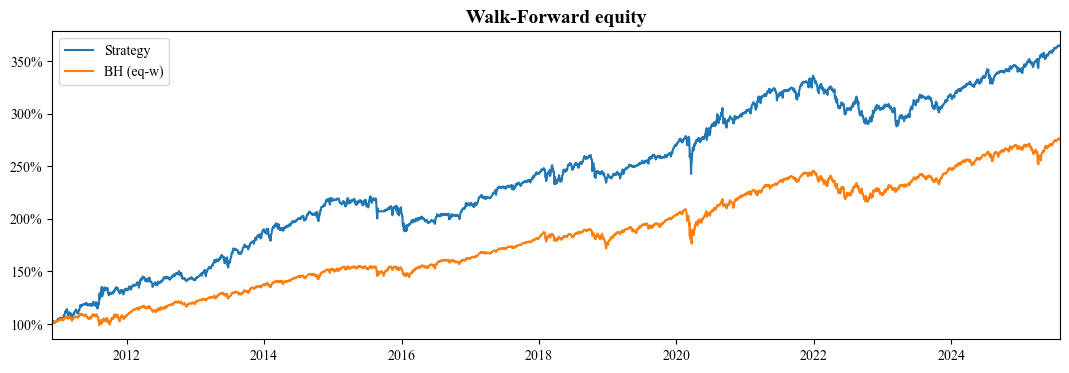

In [40]:
stats = StatisticsCalc(eq_plot, bh_plot, name="ETF WF Strategy")
print(stats) # prints metrics for the strategy (name) and the BH benchmark (row "BH")

plt.figure(figsize=(13, 4))
# Cumulative wealth (linear axis): exp of cumulative log-returns +- 1 + cumulative log-returns for plotting
plt.plot((eq_plot.cumsum()).add(1), label="Strategy")
plt.plot((bh_plot.cumsum()).add(1), label="BH (eq-w)")
plt.title("Walk-Forward equity", fontdict={'fontweight': 'bold', 'fontsize': 14}) 
#plt.grid()
plt.legend()

ax = plt.gca()
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))
ax.margins(x=0)
plt.show()

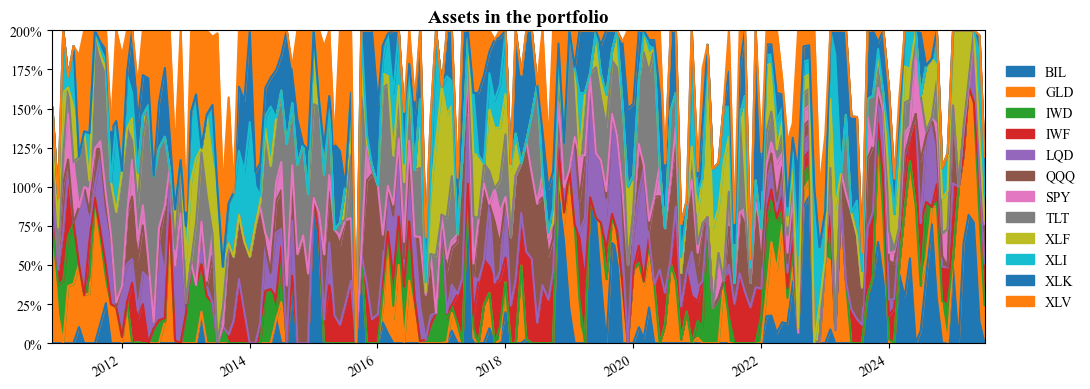

In [41]:
# Stacked area of portfolio weights (risky legs only; excludes CASH)
fig, ax = plt.subplots(figsize=(11, 4))  # растянули рисунок
wts.drop(columns='CASH').clip(lower=0).plot(kind='area', stacked=True, ax=ax)

ymax = estimator.get_params().get('budget', 1.0) if 'estimator' in globals() else None # upper limit of the y-axis = optimizer budget (if available), 
if ymax is not None: ax.set_ylim(0, ymax)                                              # else auto-scale

ax.yaxis.set_major_formatter(PercentFormatter(xmax=1)) # percentages on the axis Y
ax.margins(x=0)  # removing the empty fields by X
ax.legend(loc='center left', bbox_to_anchor=(1.01, 0.5), frameon=False, ncol=1) # легенду за пределы графика

plt.title('Assets in the portfolio', fontdict={'fontweight': 'bold', 'fontsize': 14})
plt.tight_layout()

In [42]:
wts.tail(40)

,BIL,GLD,IWD,IWF,LQD,QQQ,SPY,TLT,XLF,XLI,XLK,XLV,CASH
2022-04-01,0.065565,0.399990,0.314989,0.016889,0.054284,0.057887,0.239656,0.091132,0.000000,0.179421,0.180094,0.399995,-0.999903
2022-05-02,0.132631,0.622684,0.089557,0.087786,0.106974,0.086851,0.089092,0.113474,0.087174,0.087774,0.086137,0.092680,-0.682813
2022-06-01,0.125585,0.098398,0.065578,0.062611,0.099830,0.061117,0.064725,0.113346,0.059537,0.062770,0.060210,0.411188,-0.284894
2022-07-01,0.393569,0.093418,0.091501,0.091294,0.093492,0.091185,0.091430,0.094297,0.091088,0.091304,0.091132,0.091816,-0.405527
2022-08-01,0.065311,0.001944,0.000000,0.000000,0.000000,0.000000,0.000000,0.029797,0.000000,0.465272,0.527641,0.909999,-0.999964
2022-09-01,0.869996,0.107315,0.101126,0.100447,0.107557,0.100098,0.100905,0.110147,0.099789,0.100472,0.099858,0.102177,-0.999887
2022-10-03,0.939998,0.103157,0.093998,0.092968,0.103556,0.092439,0.093667,0.107356,0.092037,0.093018,0.092084,0.095578,-0.999857
2022-11-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.999990,0.000000,0.999984,-0.999975
2022-12-01,0.000000,0.000000,0.014299,0.000000,0.000000,0.000000,0.000000,0.000000,0.223596,0.376677,0.000000,0.376668,0.008759
2023-01-03,0.000000,0.552025,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.292702,0.000000,0.485450,-0.330177
